# Exercise #2: Performing analysis on MD trajectories

In the previous exercise, we saw how to initialize and run a molecular dynamics simulation with OpenMM. In this notebook, we will demonstrate the various tools available to analyze more in depth the output of the MD simulation, and we will focus on:
- the statistical structure of the materials
- the dynamics of their framework
- thermodynamic information derived from energies

We will use the same system as the previous notebook, a NaCl crystal in a 4×4×4 supercell.

In [1]:
%%bash
[[ -z "$COLAB_RELEASE_TAG" ]] && exit
# Install required packages if running on Google Colab
pip install mdanalysis nglview openmm

In [2]:
from io import StringIO
import tempfile
import warnings

import numpy as np
import pandas as pd

import MDAnalysis as mda
import MDAnalysis.analysis.rdf, MDAnalysis.analysis.msd
import nglview

import openmm
import openmm.app
import openmm.unit

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False

## Wrapping the MD simulation inside a function

In this notebook, we focus on the analysis of the results, and not on the setting up and the inner workings of the MD itself. Therefore, we are going to wrap the entire simulation process (which we described in the previous notebook) inside a single function.

In [3]:
offxml = """
<ForceField>
<AtomTypes>
 <Type name="0" class="Na" element="Na" mass="22.990"/>
 <Type name="1" class="Cl" element="Cl" mass="35.453"/>
 ...
</AtomTypes>

<Residues>
 <Residue name="Na">
  <Atom name="Na" type="0"/>
 </Residue>
 <Residue name="Cl">
  <Atom name="Cl" type="1"/>
 </Residue>
</Residues>

<NonbondedForce coulomb14scale="0.0" lj14scale="0.0">
 <Atom type="0" charge="1.0" sigma="0.3330" epsilon="0.011598"/>
 <Atom type="1" charge="-1.0" sigma="0.4417" epsilon="0.493712"/>
</NonbondedForce>
</ForceField>
"""

forcefield = openmm.app.forcefield.ForceField(StringIO(offxml))

In [4]:
class ExtendedStateDataReporter(openmm.app.StateDataReporter):
    """
    An extension of OpenMM's StateDataReporter_ class, which also outputs pressure if a barostat is present
    """
    # Inspired by https://atomsmm.readthedocs.io/en/latest/_modules/atomsmm/reporters.html#ExtendedStateDataReporter
    def __init__(self, file, reportInterval, **kwargs):
        self._barostat = kwargs.pop('barostat', None)
        super().__init__(file, reportInterval, **kwargs)

    def _constructHeaders(self):
        headers = super()._constructHeaders()
        if self._barostat:
            headers.append('Pressure (atm)')
        return headers

    def _constructReportValues(self, simulation, state):
        values = super()._constructReportValues(simulation, state)
        if self._barostat:
            pressure = self._barostat.computeCurrentPressure(simulation.context)
            values.append(pressure.value_in_unit(openmm.unit.atmospheres))
        return values

Below is the most important function, `perform_nacl_md`, which is responsible for all the work. It will set up the system, force field, and MD integration, perform the molecular dynamics, and load the resulting data into Python objects.

It has several parameters:
- `temperature` of our $(N, P, T)$ ensemble.
- `pressure` of our $(N, P, T)$ ensemble.
- `nsteps`: number of MD steps to perform.
- `timestep`: ∆t, the length (in units of time) of one step of MD. Default value: 1 fs.
- `friction`: thermostat parameter, strength of the coupling with the heat bath. Default value: 1 ps<sup>–1</sup>.
- `report_frequency`: . Default value: 50.

In [5]:
def perform_nacl_md(temperature, pressure, nsteps,
                    timestep = 0.001 * openmm.unit.picoseconds,
                    friction = 1. / openmm.unit.picoseconds,
                    report_frequency = 50):
    """
    Perform a MD simulation of NaCl 4x4x4 supercell in the NPT ensemble,
    at specific temperature and pressure. Return the data and trajectory.
    """

    # Read the starting configuration
    pdb = openmm.app.pdbfile.PDBFile('NaCl_4x4x4.pdb')

    # Check that the force field covers all atom types in the input structure
    unmatched_residues = forcefield.getUnmatchedResidues(pdb.topology)
    assert len(unmatched_residues) == 0

    # Create the system and add a barostat
    system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffPeriodic, nonbondedCutoff=1.1)
    barostat = openmm.MonteCarloBarostat(pressure, temperature)
    system.addForce(barostat)

    # Specify how the integration should be performed
    integrator = openmm.LangevinMiddleIntegrator(temperature, friction, timestep)
    simulation = openmm.app.Simulation(pdb.topology, system, integrator)

    # Set up the initial state: positions and velocities
    simulation.context.setPositions(pdb.positions)
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperature)

    # Output data to temporary files
    with tempfile.TemporaryDirectory() as tmpdir:
        # Write trajectory
        dcd_reporter = openmm.app.DCDReporter(f'{tmpdir}/md_trajectory.dcd', report_frequency, enforcePeriodicBox=False)
        simulation.reporters.append(dcd_reporter)

        # Output numerical data
        data_reporter = ExtendedStateDataReporter(f'{tmpdir}/md_data.csv', report_frequency,
            step=True, time=True, potentialEnergy=True, kineticEnergy=True,
            volume=True, temperature=True, density=True, barostat=barostat,
        )
        simulation.reporters.append(data_reporter)

        # Run the simulation
        simulation.step(nsteps)

        # Gather the numerical data
        data = pd.read_csv(f'{tmpdir}/md_data.csv')

        # Read the trajectory
        with warnings.catch_warnings():
            # Ignore "DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace"
            warnings.filterwarnings("ignore", category=DeprecationWarning)
            traj = mda.Universe('NaCl_4x4x4.pdb', f'{tmpdir}/md_trajectory.dcd')
            # Trajectory file will soon be removed, so we must force the trajectory in memory
            traj.transfer_to_memory()

        # Return data and trajectory
        return data, traj

What are the values returned by the `perform_nacl_md` function? There are two:
- the numerical data as a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
- the trajectory as an [`madanalysis.Universe`](https://userguide.mdanalysis.org/stable/universe.html)

We will see below how it can be exploited.

## Checking that it works

Let's perform a molecular dynamics. We'll change things a bit, and work at high temperature (1500 K) and ambient pressure (1 bar).

In [6]:
%%time
data, traj = perform_nacl_md(1500. * openmm.unit.kelvin, 1. * openmm.unit.bar, 50000)

CPU times: user 2.07 s, sys: 1.27 s, total: 3.35 s
Wall time: 6.02 s


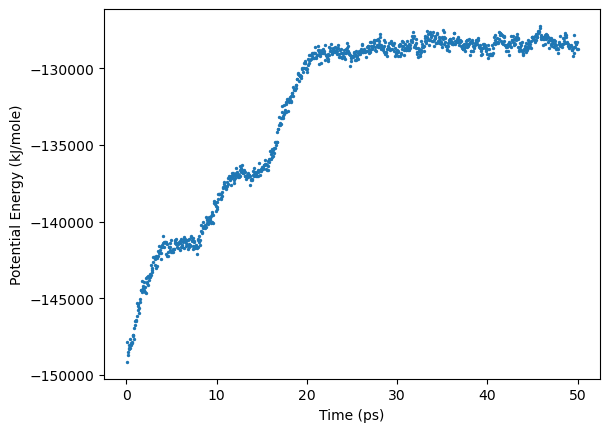

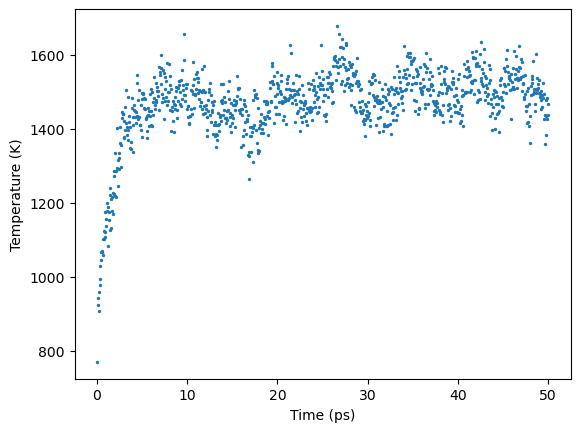

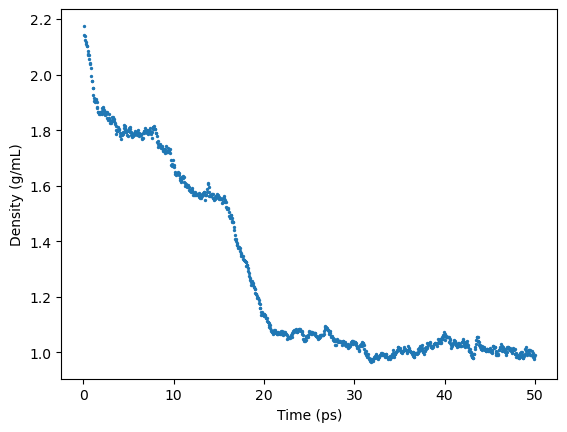

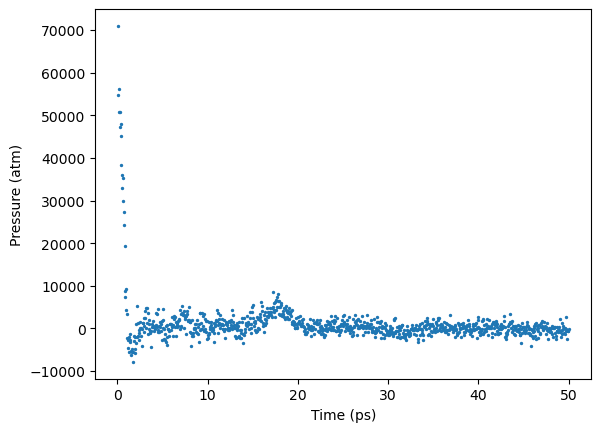

In [7]:
data.plot.scatter(x='Time (ps)', y='Potential Energy (kJ/mole)', s=2);
data.plot.scatter(x='Time (ps)', y='Temperature (K)', s=2);
data.plot.scatter(x='Time (ps)', y='Density (g/mL)', s=2);
data.plot.scatter(x='Time (ps)', y='Pressure (atm)', s=2);

In [8]:
view = nglview.show_mdanalysis(traj)
view.camera = 'orthographic'
view

NGLWidget(max_frame=999)

Let's interpret the output of this simulation.
- There appear to be three different “phases” to the system's evolution. What do they correspond to physically?
- After stabilizing, we can see that the potential energy of the system is increasing in the third phase. How can we explain that increase? What is driving this evolution?
- Why are the atoms all moving away? Does that mean that periodic boundary conditions are not applied?

## Radial distribution functions (RDF)

When we analyze the structure of condensed matter phases (solids or liquids), one key quantity of interest is the [Radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function) or RDF. The $g_{ij}(r)$ RDF represents the distribution of atoms $j$ around each atom $i$, as a function of distance $r$.

The RDF is the simplest case of a very powerful concept, that of [two-body correlation functions](https://en.wikipedia.org/wiki/Correlation_function_(statistical_mechanics)). It is the radial part of the two-particle density correlation function.

We can compute RDFs between different selections of atoms in our system through the [`MDAnalysis.analysis.rdf`](https://docs.mdanalysis.org/stable/documentation_pages/analysis/rdf.html#module-MDAnalysis.analysis.rdf) module. To make it simple, we wrap it into a `compute_rdf` function, which will:
- select two types of atoms (defaulting to selecting all atoms)
- compute the RDF over the trajectory (or possibly a subset of frames, from `start` to `stop`)
- return the output as a `pandas.DataFrame`

In [9]:
def compute_rdf(trajectory, typeA = 'all', typeB = None, rrange=(0, 12), nbins=75,
                start=None, stop=None):
    """
    Compute the Radial Distribution Function (RDF) between two atom selections ('all' by default).
    Return the results as a pandas DataFrame.
    """
    selectA = trajectory.select_atoms(typeA)
    if typeB == None or typeB == typeA:
        rdf = mda.analysis.rdf.InterRDF(selectA, selectA, exclusion_block=(1,1), range=rrange, nbins=nbins)
    else:
        selectB = trajectory.select_atoms(typeB)
        rdf = mda.analysis.rdf.InterRDF(selectA, selectB, range=rrange, nbins=nbins)

    rdf.run(start, stop)
    return pd.DataFrame({'distance': rdf.results.bins, 'RDF': rdf.results.rdf})

In order to understand clearly what is happening, it's simpler to start by calculating the RDF of a low-temperature crystal, where atoms are very ordered. We'll perform a reference calculation of NaCl at 100 K.

In [10]:
%%time
data_crystal, traj_crystal = perform_nacl_md(100. * openmm.unit.kelvin, 1. * openmm.unit.bar, 10000)

CPU times: user 581 ms, sys: 360 ms, total: 941 ms
Wall time: 1.42 s


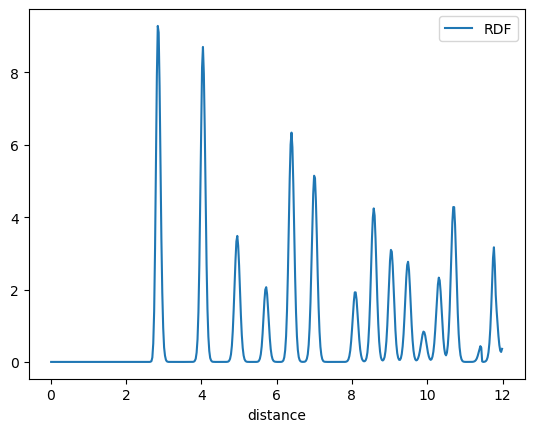

In [11]:
compute_rdf(traj_crystal, nbins=500).plot(x='distance', y='RDF');

We can see peaks corresponding to different neighbor distances between atoms, with different heights linked to the number of neighbors. That's a lot of peaks, but we can split it between contributions of different atom pairs: Na–Cl, Na–Na and Cl–Cl:

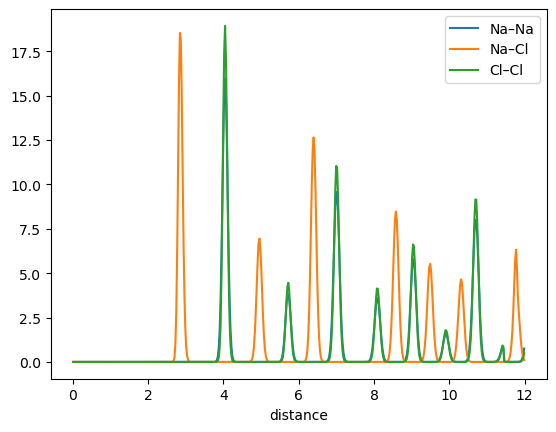

In [12]:
ax1 = compute_rdf(traj_crystal, 'name Na', 'name Na', nbins=500).plot(x='distance', y='RDF', label='Na–Na')
compute_rdf(traj_crystal, 'name Na', 'name Cl', nbins=500).plot(x='distance', y='RDF', label='Na–Cl', ax=ax1)
compute_rdf(traj_crystal, 'name Cl', 'name Cl', nbins=500).plot(x='distance', y='RDF', label='Cl–Cl', ax=ax1);

- Can you match the distances with the unit cell parameters of NaCl?
- The Na–Na and Cl–Cl radial distribution functions appear exactly identical. Can you explain why?

Now let's try to compare the RDFs at different temperatures. We'll focus on the Na–Cl pairs, because they are the closest neighbors. We'll compare 100 K, 800 K and 1500 K.

In [13]:
%%time
data_crystal_highT, traj_crystal_highT = perform_nacl_md(800. * openmm.unit.kelvin, 1. * openmm.unit.bar, 10000)

CPU times: user 556 ms, sys: 292 ms, total: 847 ms
Wall time: 1.3 s


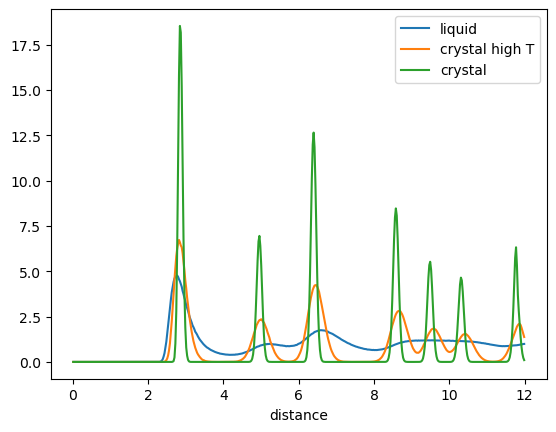

In [14]:
ax1 = compute_rdf(traj, 'name Na', 'name Cl', nbins=500).plot(x='distance', y='RDF', label='liquid')
compute_rdf(traj_crystal_highT, 'name Na', 'name Cl', nbins=500).plot(x='distance', y='RDF', label='crystal high T', ax=ax1);
compute_rdf(traj_crystal, 'name Na', 'name Cl', nbins=500).plot(x='distance', y='RDF', label='crystal', ax=ax1);

Can you interpret what is happening?

## Mean square displacement (MSD)

We next turn our interest to dynamical properties. We will compute here the [mean square displacement (MSD)](https://en.wikipedia.org/wiki/Mean_squared_displacement), a measure of the movement of the positions of the particles in the system over time. We use the [`MDAnalysis.analysis.msd.EinsteinMSD`](https://docs.mdanalysis.org/stable/documentation_pages/analysis/msd.html) function to calculate it, and wrap this in our own function to make things simpler:

In [15]:
def compute_msd(trajectory, select='all', msd_type='xyz', fft=True, **kwargs):
    MSD = MDAnalysis.analysis.msd.EinsteinMSD(trajectory, select=select, msd_type=msd_type, fft=fft)
    # For some reason, passing verbose=False does not actually disable the progress bar
    # https://github.com/MDAnalysis/mdanalysis/issues/5144
    MSD.run(verbose=False, **kwargs)
    return pd.DataFrame({'MSD': MSD.results.timeseries, 'time': MSD.results.delta_t_values})

We first try it on our high-temperature simulation, i.e., in the liquid phase:

100%|███████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6594.72it/s]


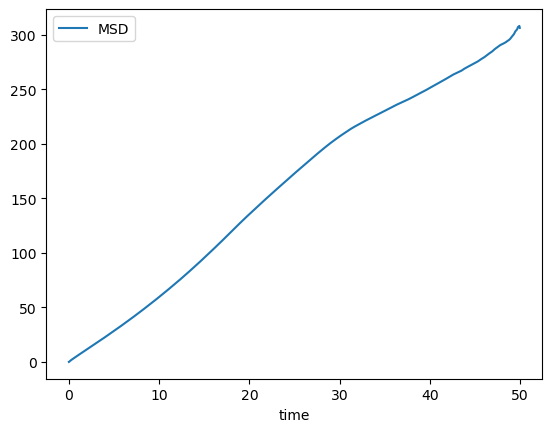

In [16]:
ax1 = compute_msd(traj).plot(x='time', y='MSD')

We can see that the MSD increases over time, and it seems logical: the atoms are moving. In fact, the [theory of Brownian motion]() tells us that the MSD over time should follow a linear law in $n$ dimensions, if the motion of the particles is diffusive:
$$ \text{MSD}(t) \sim 2n\, D\, t $$
for sufficiently large values of $t$ (i.e., $t \rightarrow \infty$). If so, then $D$ is the diffusion coefficient. We can try a linear fit of our curve above:

100%|███████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6722.97it/s]


Regression: MSD ~ 6.2705 * t + 4.0308


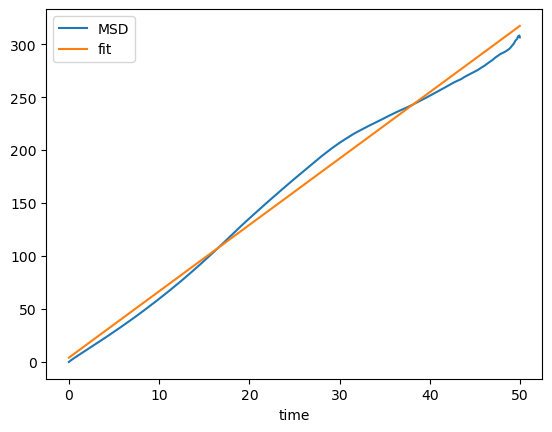

In [17]:
import scipy
res = compute_msd(traj)
regression = scipy.stats.linregress(res['time'], res['MSD'])
res['fit'] = regression.intercept + regression.slope*res['time']

ax1 = res.plot(x='time', y='MSD')
ax1 = res.plot(x='time', y='fit', ax=ax1)
print(f'Regression: MSD ~ {regression.slope:.4f} * t + {regression.intercept:.4f}')

The diffusion coefficient would be slope / 6. We find a value of $D \approx 1$… **but what unit? How does it compare to typical values of diffusivity in molten salts?**

This analysis is a bit limited because diffusivity happens at timescales that are closer to ns that ps, so our simulation is a bit short for quantitative analysis. We can, however, compare this behavior of the liquid to that of the solid phases:

100%|██████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 18080.42it/s]


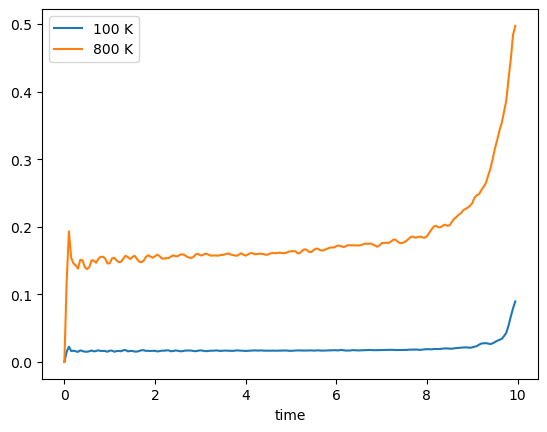

In [18]:
ax1 = compute_msd(traj_crystal).plot(x='time', y='MSD', label='100 K')
compute_msd(traj_crystal_highT).plot(x='time', y='MSD', label='800 K', ax=ax1);

That increase at the end is not actually physical, it comes from the fast that we calculated the MSD over the whole trajectory, including the begining where the system is not equilibrated and the dynamics is not representative of the equilibrium. We can remove the first 20 frames (10% of the trajectory) using the `start` keyword to our `compute_msd()` function.

Length of the trajectory: 200


100%|██████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 18792.41it/s]


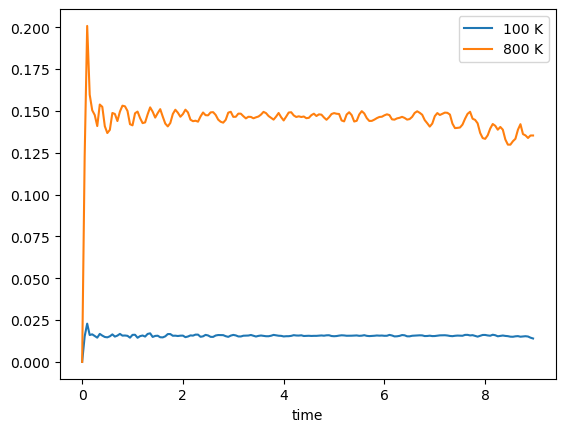

In [19]:
print('Length of the trajectory:', len(traj_crystal.trajectory))
ax1 = compute_msd(traj_crystal, start=20).plot(x='time', y='MSD', label='100 K')
compute_msd(traj_crystal_highT, start=20).plot(x='time', y='MSD', label='800 K', ax=ax1);

<span style="color:blue">**What can you conclude about the MSD of the crystalline phase of NaCl? How about the influence of temperature?**</span>

We can do one more analysis, which is to have a look at the difference between atom types:

100%|██████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 17491.07it/s]


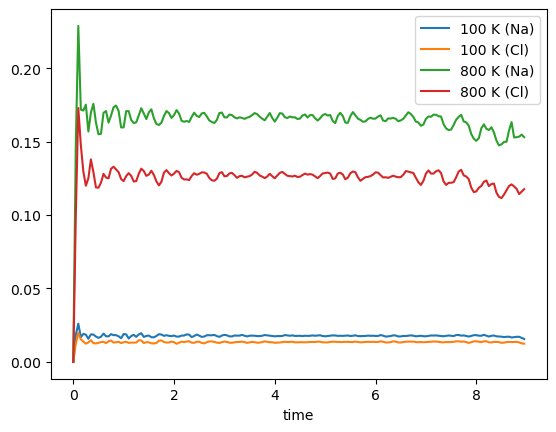

In [20]:
ax1 = compute_msd(traj_crystal, 'name Na', start=20).plot(x='time', y='MSD', label='100 K (Na)')
compute_msd(traj_crystal, 'name Cl', start=20).plot(x='time', y='MSD', label='100 K (Cl)', ax=ax1)
compute_msd(traj_crystal_highT, 'name Na', start=20).plot(x='time', y='MSD', label='800 K (Na)', ax=ax1);
compute_msd(traj_crystal_highT, 'name Cl', start=20).plot(x='time', y='MSD', label='800 K (Cl)', ax=ax1);

100%|███████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 8665.29it/s]


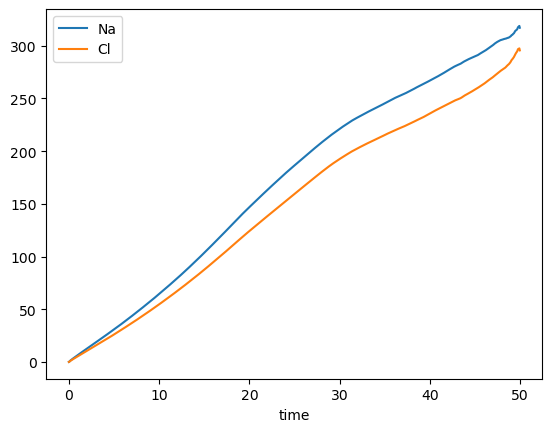

In [21]:
ax1 = compute_msd(traj, 'name Na').plot(x='time', y='MSD', label='Na')
compute_msd(traj, 'name Cl').plot(x='time', y='MSD', label='Cl', ax=ax1);